In [1]:
import audiolabel
import parselmouth as ps  # This provides Praat functionality within python
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA  # This provides linear algebra helper functions for calculating distances, which we use in the function apPal

pd.options.mode.chained_assignment = None  # default='warn'; this line suppresses some warnings from pandas

# Unit 3: XRMB

The X-Ray Microbeam Database is a set of articulatory and acoustic recordings collected in 1989-1991 at the University of Wisconsin

We have two types of raw data available -- audio recordings of a variety of speech tasks taken on by speakers in the study (**audio**) and the positions of pellets glued to different parts of speakers' jaw, tongue, lips, and face during these speech tasks (**xrmb**). We also have access to annotations in the form of TextGrids generated using forced alignment by Keith Johnson for a previous course. 
These data have the following file structure and naming conventions:
- data
    - subject -- JW followed by a number
        - PAL.DAT -- the palate trace for the subject
        - PHA.DAT -- the approximated pharyngeal trace for the subject
        - taN.wav -- audio recordings without accompanying xrmb data
        - tpN.wav -- audio recordings *with* accompanying xrmb data
        - tpN.txy -- accompanying xrmb data
- annotation
    - subject -- same as above
        - tpN.TextGrid -- accompanying forced aligned annotations; these have the typical forced aligned structure of words on tier 1 and phones on tier 2

In [2]:
annotations = os.path.abspath('./annotation')
datadir = os.path.abspath('./data')

## Getting to know the xrmb data

Let's check out some data and see what we're working with! First we can establish a list of the subjects, and then pick one of them and look at their files.

In [3]:
subjects = [s for s in os.listdir(datadir) if os.path.isdir(os.path.join(datadir,s))]
len(subjects) # how many subjects are there?

48

## Manipulating the xrmb data

There are many different kinds of questions we might try to answer with these data. The specific question we are trying to replicate is (in two parts)
1. Are tongue tip constrictions in post-vocalic /l/s weaker preceding bilabial and velar stops compared to alveolar stops?
2. Is this difference between magnitude of constriction affected by lexical frequency whereby more frequent words show weaker constrictions than stronger words?

One manipulation we'll need is to measure the distance between the tongue tip (T1) and the palate trace, aka "tongue tip aperture". We'll find all of the distances from the T1 point to every point on the palate and give the minimum of those points, as well as the spot on the palate resulting in that minimum.
(Another, almost certaily faster, way to approach this same question is to use the y-cooridinate of T1 as a proxy for tongue height.)

The following is a function that determines the distance between the palate and any tongue point using the method above. 
- It takes as input the **row** of data from the xrmb dataframe, the dataframe containing the palate trace **paldf**, and the number of the point to measure distance from **TN**.
- It returns the distance between that point and the palate trace

In [4]:
def apPal(row, paldf, TN):
    
    xval=row[''.join(['T',str(TN),'x'])]
    yval=row[''.join(['T',str(TN),'y'])]
    paltemp = paldf.copy()
    paltemp['ap']=paltemp.apply(lambda x: LA.norm(np.array([xval,yval])-np.array([x.x, x.y])), axis=1)
    
    return paltemp.iloc[paltemp['ap'].argmin()]

In [5]:
names=[
    'time', 'ULx', 'ULy', 'LLx', 'LLy', 'T1x', 'T1y', 'T2x', 'T2y',
    'T3x', 'T3y', 'T4x', 'T4y', 'MIx', 'MIy', 'MMx', 'MMy'
]

**This is the cell where you'll make most changes for gathering data.**

In [6]:
alldf = pd.DataFrame()

# for sub in subjects[0:1]  ## you can uncomment this if you want to test just a single subject before running it on everyone
for sub in subjects:
    
    subdata = os.path.join(datadir,sub)
    subannotations = os.path.join(annotations,sub)
    xfiles = [f for f in os.listdir(subdata) if f[-4:]=='.txy']  # These are the xray files
    tgfiles = [f for f in os.listdir(subannotations) if f[-9:]=='.TextGrid']  # We don't really need to check if they are TextGrids but it's still nice to

    palfile = os.path.join(subdata, 'PAL.DAT')
    phafile = os.path.join(subdata, 'PHA.DAT')
    paldf = pd.read_table(palfile, sep='\s+', header=None, names=['x', 'y'])/1000
    phadf = pd.read_table(phafile, sep='\s+', header=None, names=['x', 'y'])/1000
    
    for f in xfiles:
        prefix = f[:-4]
        try:
            xdata = pd.read_table(os.path.join(subdata,prefix+'.txy'),names=names)

            xdata = xdata.replace(1000000,np.nan)
            xdata = xdata/1000
            xdata.time = xdata.time/1000

            if not os.path.isfile(os.path.join(annotations,sub,prefix+'.TextGrid')):
                print(' '.join(["No annotation found for",sub,prefix]))
                continue

            tg = audiolabel.LabelManager(from_file=os.path.join(annotations,sub,prefix+'.TextGrid'),from_type='praat')
            [phonedf, worddf] = tg.as_df()

            phonedf=phonedf.rename(columns={"text":"phone"})
            phonedf['phoneprev'] = phonedf.phone.shift()
            phonedf['phonenext'] = phonedf.phone.shift(-1)
            worddf=worddf.rename(columns={"text":"word"})
            timesdf = pd.merge_asof(phonedf, worddf, on='t1')
            timesdf=timesdf.rename(columns={"t2_x":"t2"})
            timesdf=timesdf[['t1','t2','phone','phoneprev','phonenext','word']]
            timesdf['wordonset'] = ~(timesdf.word==timesdf.word.shift())
            timesdf['wordend'] = ~(timesdf.word==timesdf.word.shift(-1))
            timesdf = timesdf.replace(np.nan,'')
            timesdf['postvocalic'] = timesdf.phoneprev.apply(lambda x: len(x)==3)
            timesdf['prevocalic'] = timesdf.phonenext.apply(lambda x: len(x)==3)

            xdata = pd.merge_asof(xdata, timesdf, left_on='time', right_on='t1')

            # edit the next line for the segment(s) you're interested in
            segdf = xdata[((xdata.phone=='T') | (xdata.phone=='D'))  # gets /t,d/
                           & xdata.postvocalic & xdata.prevocalic  # gets intervocalic segments only
                           & ~(xdata.wordend | xdata.wordonset)]
            segdf['file']=prefix
            segdf['subject']=sub

            if len(segdf)>0:  # edit these two lines for the points you are interested in
                segdf['T1ap'] = segdf.apply(lambda x: apPal(x, paldf, 1), axis=1).ap
                alldf = pd.concat([alldf,segdf])
        except:
            print(' '.join(["Error for",sub,prefix]))
    
print('Done!')

No annotation found for JW21 tp117
No annotation found for JW21 tp118_2
No annotation found for JW21 tp106
No annotation found for JW21 tp118
No annotation found for JW19 tp117
No annotation found for JW19 tp106
No annotation found for JW19 tp118
No annotation found for JW502 tp106_3
No annotation found for JW502 tp106_2
No annotation found for JW502 tp116
No annotation found for JW502 tp117
No annotation found for JW502 tp115
No annotation found for JW502 tp114
No annotation found for JW502 tp110
No annotation found for JW502 tp111
No annotation found for JW502 tp107
No annotation found for JW502 tp113
No annotation found for JW502 tp112
No annotation found for JW502 tp106
No annotation found for JW502 tp108
No annotation found for JW502 tp109
No annotation found for JW502 tp118
No annotation found for JW502 tp117_2
No annotation found for JW26 tp116
No annotation found for JW26 tp117
No annotation found for JW26 tp115
No annotation found for JW26 tp114
No annotation found for JW26 tp

In [7]:
alldf

,time,ULx,ULy,LLx,LLy,T1x,T1y,T2x,T2y,T3x,...,phoneprev,phonenext,word,wordonset,wordend,postvocalic,prevocalic,file,subject,T1ap
774,5.314284,14.423,12.785,10.013,-14.900,-14.633,12.114,-24.934,13.988,-38.809,...,AH0,AO2,DORMITORY,False,False,True,True,tp001,JW21,4.089866
775,5.321150,14.487,13.004,9.969,-15.063,-14.273,12.139,-24.613,13.976,-38.522,...,AH0,AO2,DORMITORY,False,False,True,True,tp001,JW21,3.749652
776,5.328016,14.561,13.205,9.972,-15.160,-13.930,12.057,-24.308,13.917,-38.238,...,AH0,AO2,DORMITORY,False,False,True,True,tp001,JW21,3.397506
777,5.334882,14.645,13.389,10.018,-15.192,-13.609,11.918,-24.021,13.816,-37.962,...,AH0,AO2,DORMITORY,False,False,True,True,tp001,JW21,3.050366
778,5.341748,14.738,13.550,10.101,-15.166,-13.317,11.765,-23.757,13.680,-37.700,...,AH0,AO2,DORMITORY,False,False,True,True,tp001,JW21,2.728389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872,5.987152,13.846,14.649,6.270,-18.312,-15.124,11.183,-30.989,16.753,-45.978,...,AY1,AH0,ITEM,False,False,True,True,tp030,JW62,3.229214
873,5.994018,13.879,14.579,6.555,-17.957,-15.074,11.053,-31.003,16.517,-46.025,...,AY1,AH0,ITEM,False,False,True,True,tp030,JW62,3.224295
874,6.000884,13.909,14.483,6.859,-17.527,-15.040,10.709,-31.054,16.230,-46.127,...,AY1,AH0,ITEM,False,False,True,True,tp030,JW62,3.328315
875,6.007750,13.933,14.354,7.189,-17.001,-15.027,10.152,-31.150,15.885,-46.291,...,AY1,AH0,ITEM,False,False,True,True,tp030,JW62,3.596773


**What question(s) are we asking?** You may need to adjust this cell.

In [8]:
summarydf = alldf.groupby(['subject','file','word','phone']).min().reset_index()
summarydf.head()

,subject,file,word,phone,time,ULx,ULy,LLx,LLy,T1x,...,MMy,t1,t2,phoneprev,phonenext,wordonset,wordend,postvocalic,prevocalic,T1ap
0,JW11,tp001,DORMITORY,T,5.080840,14.616,16.165,6.577,-20.387,-23.491,...,-4.522,5.074979,5.224043,AH0,AO2,False,False,True,True,1.478024
1,JW11,tp006,ALREADY,D,6.302988,14.092,17.749,7.367,-23.851,NaN,...,-5.378,6.302848,6.348073,EH1,IY0,False,False,True,True,NaN
2,JW11,tp010,DIRTY,T,4.634550,15.412,18.432,10.254,-18.401,-19.591,...,-4.104,4.632974,4.664503,ER1,IY0,False,False,True,True,2.220689
3,JW11,tp010,WATER,T,8.246066,15.469,18.489,9.248,-21.028,-24.363,...,-6.623,8.244214,8.269174,AO1,ER0,False,False,True,True,5.069247
4,JW11,tp016,UHDA,D,20.398886,13.813,17.605,9.355,-23.528,-20.212,...,-4.550,20.396100,20.545800,AH0,AA1,False,False,True,True,2.517448


<AxesSubplot:xlabel='phone', ylabel='T1ap'>

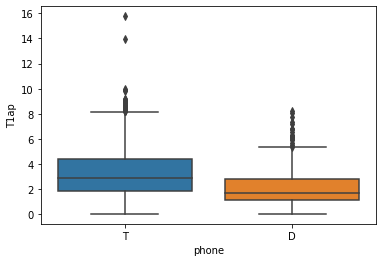

In [9]:
sns.boxplot(x='phone',y='T1ap',data=summarydf)

## Lexical Frequency effects

We might also wonder about lexical frequency and its relationship with articulation. Based on our readings, we might expect more frequent words to enhance reduction processes, so that, all else being equal, more frequent words have weaker constrictions.
To see whether that is occurring in our data, we will need to combine our articulatory data with 

As discussed in class, one good database for lexical frequency is [SUBTLEX](https://www.ugent.be/pp/experimentele-psychologie/en/research/documents/subtlexus).
Let's have a look at this data. We can see words and their frequencies, which are calculated in quite a few ways. You can check out the description in the documentation linked above; for our purposes, we'll probably want to use "Lg10WF", which is log-transformed.

In [10]:
freqdf = pd.read_table('./SUBTLEXus74286wordstextversion.txt')
freqdf.head(10)

,Word,FREQcount,CDcount,FREQlow,Cdlow,SUBTLWF,Lg10WF,SUBTLCD,Lg10CD
0,the,1501908,8388,1339811,8388,29449.18,6.1766,100.00,3.9237
1,to,1156570,8383,1138435,8380,22677.84,6.0632,99.94,3.9235
2,a,1041179,8382,976941,8380,20415.27,6.0175,99.93,3.9234
3,you,2134713,8381,1595028,8376,41857.12,6.3293,99.92,3.9233
4,and,682780,8379,515365,8374,13387.84,5.8343,99.89,3.9232
5,it,963712,8377,685089,8370,18896.31,5.9839,99.87,3.9231
6,s,1057301,8377,1052788,8373,20731.39,6.0242,99.87,3.9231
7,of,590439,8375,573021,8372,11577.24,5.7712,99.85,3.9230
8,for,351650,8374,332686,8370,6895.10,5.5461,99.83,3.9230
9,I,2038529,8372,5147,350,39971.16,6.3093,99.81,3.9229


We need to join the frequency and l dataframes, but we have one more problem to handle -- the words from the XRMB database are in all capital letters while the ones in SUBTLEX are primarily lowercase but with proper names and acronyms capitalized.
We can handle this by creating a new column in _both_ dataframes called 'wordlc' which is equivalent to the 'word' columns, but only lowercase letters.

In [11]:
freqdf['wordlc']=freqdf.Word.apply(lambda x: x.lower() if type(x)==str else x)
summarydf['wordlc']=summarydf.word.apply(lambda x: x.lower())
summarydf.head()

,subject,file,word,phone,time,ULx,ULy,LLx,LLy,T1x,...,t1,t2,phoneprev,phonenext,wordonset,wordend,postvocalic,prevocalic,T1ap,wordlc
0,JW11,tp001,DORMITORY,T,5.080840,14.616,16.165,6.577,-20.387,-23.491,...,5.074979,5.224043,AH0,AO2,False,False,True,True,1.478024,dormitory
1,JW11,tp006,ALREADY,D,6.302988,14.092,17.749,7.367,-23.851,NaN,...,6.302848,6.348073,EH1,IY0,False,False,True,True,NaN,already
2,JW11,tp010,DIRTY,T,4.634550,15.412,18.432,10.254,-18.401,-19.591,...,4.632974,4.664503,ER1,IY0,False,False,True,True,2.220689,dirty
3,JW11,tp010,WATER,T,8.246066,15.469,18.489,9.248,-21.028,-24.363,...,8.244214,8.269174,AO1,ER0,False,False,True,True,5.069247,water
4,JW11,tp016,UHDA,D,20.398886,13.813,17.605,9.355,-23.528,-20.212,...,20.396100,20.545800,AH0,AA1,False,False,True,True,2.517448,uhda


Now we can merge the dataframes on the newly created column.

In [12]:
summarydf = summarydf.merge(freqdf,left_on='wordlc',right_on='wordlc')
summarydf.head()

,subject,file,word,phone,time,ULx,ULy,LLx,LLy,T1x,...,wordlc,Word,FREQcount,CDcount,FREQlow,Cdlow,SUBTLWF,Lg10WF,SUBTLCD,Lg10CD
0,JW11,tp001,DORMITORY,T,5.080840,14.616,16.165,6.577,-20.387,-23.491,...,dormitory,dormitory,51,38,49,37,1.0,1.716,0.45,1.5911
1,JW11,tp018,DORMITORY,T,1.524252,NaN,NaN,4.931,-21.295,-24.597,...,dormitory,dormitory,51,38,49,37,1.0,1.716,0.45,1.5911
2,JW11,tp019,DORMITORY,T,8.561902,15.360,14.957,7.212,-20.979,-24.657,...,dormitory,dormitory,51,38,49,37,1.0,1.716,0.45,1.5911
3,JW11,tp040,DORMITORY,T,4.627684,NaN,NaN,7.729,-20.904,-22.725,...,dormitory,dormitory,51,38,49,37,1.0,1.716,0.45,1.5911
4,JW11,tp047,DORMITORY,T,1.380066,15.309,15.964,5.389,-21.993,NaN,...,dormitory,dormitory,51,38,49,37,1.0,1.716,0.45,1.5911


<AxesSubplot:xlabel='Lg10WF', ylabel='T1ap'>

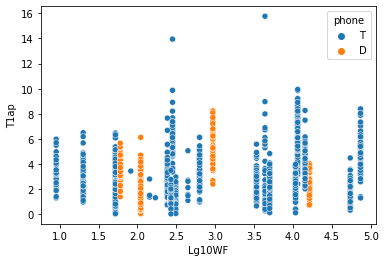

In [13]:
sns.scatterplot(x='Lg10WF', y='T1ap', data=summarydf, hue='phone')

Well one thing we're seeing here is that there is a lot of variation between individual productions. 
(Recall that each dot in this figure is from a single articulation.)
Ironically, this might not be so much an issue if we had even _more_ data, because there would be more words and therefore more x-axis variation represented. 
Since we can't get _more_ data, and while it conceals quite a lot of variation, we might have a better "view" if we summarized the data per word.

In [19]:
combinedf=summarydf.groupby(['word','phone','phoneprev']).mean().reset_index()
combinedf

,word,phone,phoneprev,time,ULx,ULy,LLx,LLy,T1x,T1y,...,prevocalic,T1ap,FREQcount,CDcount,FREQlow,Cdlow,SUBTLWF,Lg10WF,SUBTLCD,Lg10CD
0,AFFIRMATIVE,T,AH0,3.394747,12.658224,12.681041,10.583490,-12.103776,-15.884633,6.244347,...,1.0,3.152760,241.0,183.0,95.0,72.0,4.73,2.3838,2.18,2.2648
1,ALREADY,D,EH1,5.387327,12.278500,13.554109,8.441652,-16.465543,-15.731000,7.027156,...,1.0,2.430735,16246.0,6350.0,15769.0,6297.0,318.55,4.2108,75.70,3.8028
2,BEAUTIFUL,T,UW1,1.273494,14.244457,13.745543,10.963283,-11.290717,-17.405565,7.329957,...,1.0,4.205294,14266.0,4973.0,12867.0,4784.0,279.73,4.1543,59.29,3.6967
3,BUTTERFLY,T,AH1,4.375015,13.109511,13.343667,10.080455,-13.781205,-21.665146,7.589220,...,1.0,6.097934,281.0,186.0,197.0,144.0,5.51,2.4502,2.22,2.2718
4,BUTTONS,T,AH1,12.956142,13.196125,13.861500,10.520750,-11.125000,-12.505875,7.271375,...,1.0,2.276333,444.0,335.0,406.0,326.0,8.71,2.6484,3.99,2.5263
5,CERTAIN,T,ER1,4.998775,13.503855,13.690081,10.863873,-10.110222,-17.340937,9.003127,...,1.0,2.765518,4354.0,2654.0,4170.0,2582.0,85.37,3.6390,31.64,3.4241
6,CITATION,T,AY0,1.043632,17.597000,8.929000,11.102000,-10.844000,-19.148000,8.160000,...,1.0,3.442880,81.0,47.0,77.0,44.0,1.59,1.9138,0.56,1.6812
7,DIRTY,T,ER1,4.560517,13.444913,14.525630,10.759304,-12.013326,-19.922783,9.132717,...,1.0,2.671933,3389.0,2060.0,3007.0,1907.0,66.45,3.5302,24.56,3.3141
8,DORMITORY,T,AH0,4.687968,13.457345,13.046728,11.426260,-11.729662,-20.786015,4.802077,...,1.0,2.618909,51.0,38.0,49.0,37.0,1.00,1.7160,0.45,1.5911
9,EIGHT,T,EY1,2.873889,12.663535,13.601930,8.609977,-17.069047,-13.886136,3.292773,...,1.0,2.301230,5010.0,2682.0,3743.0,2256.0,98.24,3.6999,31.97,3.4286


<AxesSubplot:xlabel='Lg10WF', ylabel='T1ap'>

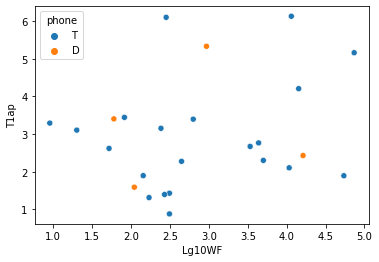

In [24]:
sns.scatterplot(x='Lg10WF', y='T1ap', data=combinedf, hue='phone')

What do we see? Do we think there is much of a relationship between word frequency (higher numbers refer to more frequent words and TT aperture (higher numbers means larger aperture and therefore weaker constriction)?

<AxesSubplot:xlabel='Lg10WF', ylabel='T1x'>

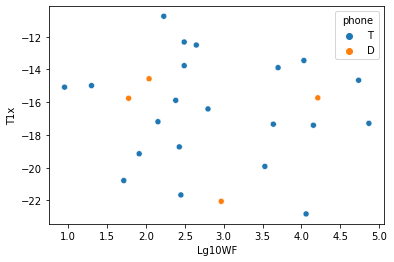

In [26]:
sns.scatterplot(x='Lg10WF', y='T1x', data=combinedf, hue='phone')